# Clustering problem

## Imports and data

#### Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import bql
bq = bql.Service()

#### Grab index members

In [2]:
bql_item = bq.data.id()
index_members= bq.univ.members('BBREIT Index')
bql_request = bql.Request(index_members, bql_item)
bql_response = bq.execute(bql_request)
ddf = bql.combined_df(bql_response)
index_members = ddf.index

#### Grab total return for each index member

In [3]:
request = "get(TOTAL_RETURN_INDEX(DATES=RANGE('-20Y', '0D'))) for(["
for m in index_members:
    request += f"'{m}',"
request = request[:-1] + "])"
res = bq.execute(request)
df = bql.combined_df(res)
df.head()
df.to_csv('df.csv')

#### Grab characteristics (features) for each index member

In [4]:
date = df['DATE'].apply(pd.to_datetime).max().date()

params_act = {'fpt': 'a',
             'dates': date,
              'fill': 'prev'
             }

params_est = {'fpt': 'ltm',
             'dates': date,
             'fpo': '1',
              'fill':'prev'
             }
params_func = {'fpt': 'a',
              'dates': bq.func.range(start=date - datetime.timedelta(days=365), end = date),
              'fill': 'prev'}

fields = {
        #  VALUE FIELDS
         'book_to_price': bq.data.px_to_book_ratio(**params_act)["value"],
         'earnings_yield': bq.data.earn_yld(**params_act)["value"],
         'free_cash_flow_yield': bq.data.free_cash_flow_yield(**params_act)["value"],
         'eqy_dvd_yld': (bq.data.is_div_per_shr(**params_est)["value"]/bq.data.px_last(dates=date))["value"],
         'stock_buyback': bq.data.cf_decr_cap_stock(**params_act)["value"],
    
        #  SIZE FIELDS
        'market_cap': bq.data.cur_mkt_cap(dates=date)["value"],
    
        # MOMENTUM
        '12m_1w_px_momentum': (bq.func.pct_chg(bq.data.px_last(start= date - datetime.timedelta(days=365), end=date-datetime.timedelta(days=7),fill='prev')))["value"],
        'tot_return_1y': bq.data.total_return(calc_interval='1y')['value'],
    
        # LOW VOLATILITY
        'volatility_1y': (bq.data.volatility(calc_interval=bq.func.range(start= date- datetime.timedelta(days=365),end=date)))["value"],
        
        #  QUALITY   
        # Profitability
        'roe': bq.data.return_com_eqy(**params_act)["value"],
        'oper_csh_flow_to_assets': bq.data.CF_CASH_FROM_OPER(**params_act)["value"]/bq.data.net_assets(**params_act)["value"],
    
        # Leverage
        'net_debt_to_assets': (bq.data.net_debt(**params_act)/bq.data.net_assets(**params_act))["value"],
        'net_debt_to_ebitda': (bq.data.net_debt(**params_act)/bq.data.ebitda(**params_act))["value"],
        'delta_return_assets': (bq.data.return_on_asset(**params_act)-bq.data.return_on_asset(**params_act,fa_period_offset='-1'))["value"],
        'delta_leverage': (bq.data.bs_tot_asset(**params_act)/bq.data.tot_common_eqy(**params_act))["value"],
        'eqy_issuance': (bq.data.BS_SH_OUT(**params_act)- bq.data.bs_sh_out(**params_act,fa_period_offset='-1'))["value"],
        'delta_asset_turnover': bq.data.asset_turnover(**params_act)-bq.data.asset_turnover(**params_act, fa_period_offset='-1')["value"],
        'roa_variability': bq.func.std(bq.data.return_on_asset(**params_func))["value"],
        'revenue_growth_variability': bq.func.std(bq.data.sales_rev_turn(**params_func))["value"],
}

fdf = pd.DataFrame()
for m in index_members:
    try:
        req = bql.Request(universe=[m], items=fields)
        resp = bq.execute(req)
        fdf = fdf.append(bql.combined_df(resp), sort=False)
    except:
        print(m)
fdf.head()
fdf.to_csv('fdf.csv')

## Clustering on correlations

This is the standard type of clustering in Finance, cluster assets by correlations:

In [5]:
import scipy.cluster.hierarchy as sch

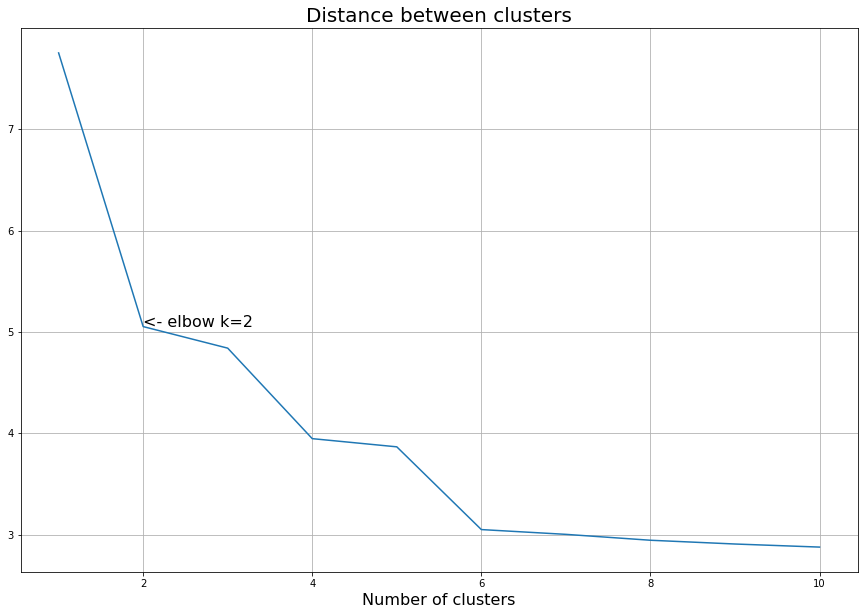

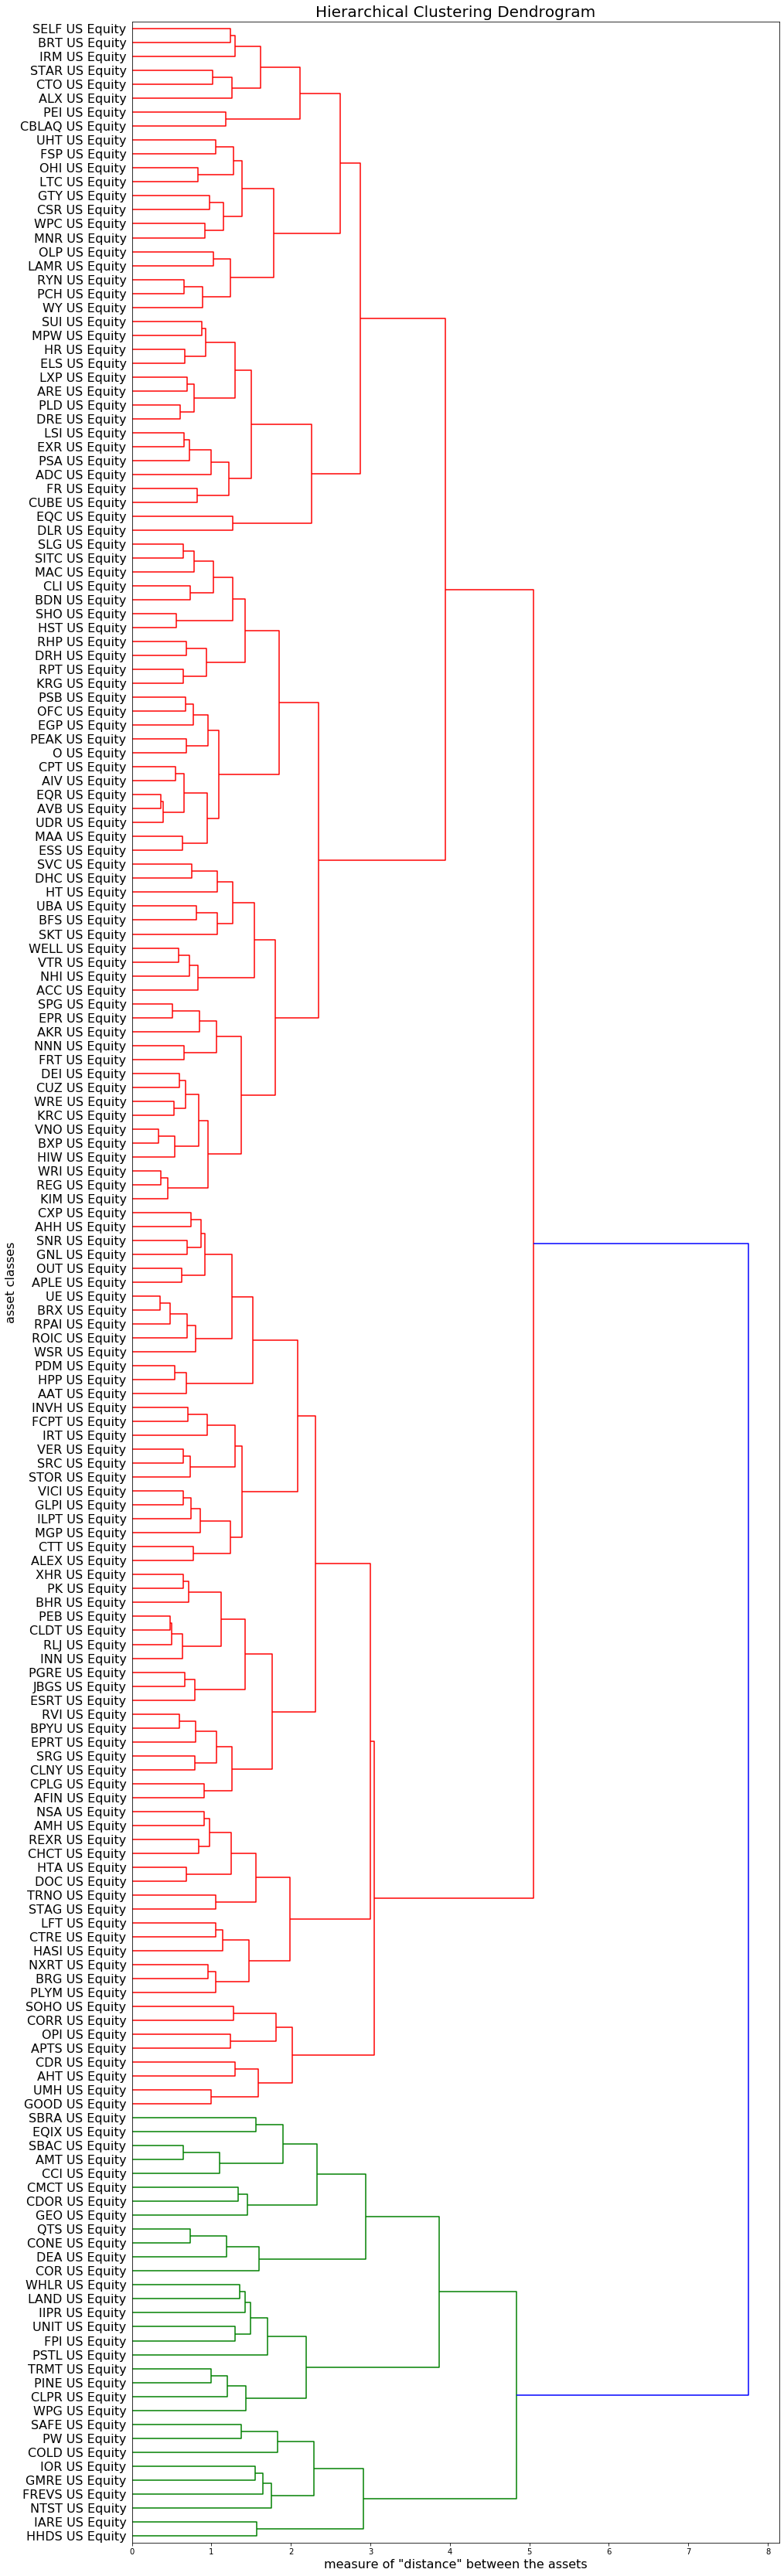

In [6]:
corr = df.pivot_table(index='DATE', columns='ID').pct_change(21).corr().droplevel(0).droplevel(0, axis=1)
dist_matrix = sch.distance.pdist(corr.values)
Z = sch.linkage(dist_matrix, method='complete')
last = Z[-10:, 2]
last_rev = last[::-1] # revert order
idxs = np.arange(1, len(last) + 1)

# The point with largest 2nd diff is the elbow
k = np.diff(last_rev, 2).argmax() + 1

# plot
plt.figure(0, figsize=(15, 10))
plt.plot(idxs, last_rev)
plt.text(k+1, last_rev[k],
         '<- elbow k=%s' % str(k + 1), fontsize=16)
plt.xlabel('Number of clusters', fontsize=16)
plt.title('Distance between clusters', fontsize=20)
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 60))
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.xlabel('measure of "distance" between the assets', fontsize=16)
plt.ylabel('asset classes', fontsize=16)
sch.dendrogram(
    Z,
    labels=corr.index,
    orientation='right',
    distance_sort='ascending',
    leaf_font_size=16
)
plt.show()

Despite the elbow method classifying the assets in two groups, let's go with 6 groups:

In [7]:
clusters = pd.Series(index=corr.columns, data=sch.fcluster(Z, 6, criterion='maxclust')).sort_values()
large_text = ''
for i in sorted(list(set(clusters.values))):
    print('Cluster #%s is:' % str(i))
    large_text += '\nCluster #%s is:' % str(i)
    for j in clusters[clusters == i].index:
        print(j)
        large_text += '\n' + j
    print('______________________')
    large_text += '\n______________________'

Cluster #1 is:
IOR US Equity
NTST US Equity
SAFE US Equity
PW US Equity
HHDS US Equity
IARE US Equity
FREVS US Equity
GMRE US Equity
COLD US Equity
______________________
Cluster #2 is:
UNIT US Equity
WHLR US Equity
WPG US Equity
TRMT US Equity
IIPR US Equity
PSTL US Equity
LAND US Equity
CLPR US Equity
PINE US Equity
FPI US Equity
______________________
Cluster #3 is:
CONE US Equity
COR US Equity
DEA US Equity
QTS US Equity
EQIX US Equity
CMCT US Equity
CDOR US Equity
GEO US Equity
SBAC US Equity
SBRA US Equity
AMT US Equity
CCI US Equity
______________________
Cluster #4 is:
REXR US Equity
JBGS US Equity
IRT US Equity
STOR US Equity
INVH US Equity
INN US Equity
ILPT US Equity
TRNO US Equity
HTA US Equity
HPP US Equity
UMH US Equity
HASI US Equity
GOOD US Equity
VER US Equity
GNL US Equity
VICI US Equity
WSR US Equity
UE US Equity
STAG US Equity
MGP US Equity
SRG US Equity
RLJ US Equity
ROIC US Equity
RPAI US Equity
PLYM US Equity
RVI US Equity
GLPI US Equity
SNR US Equity
PK US Equit

## Clustering on characteristics or features

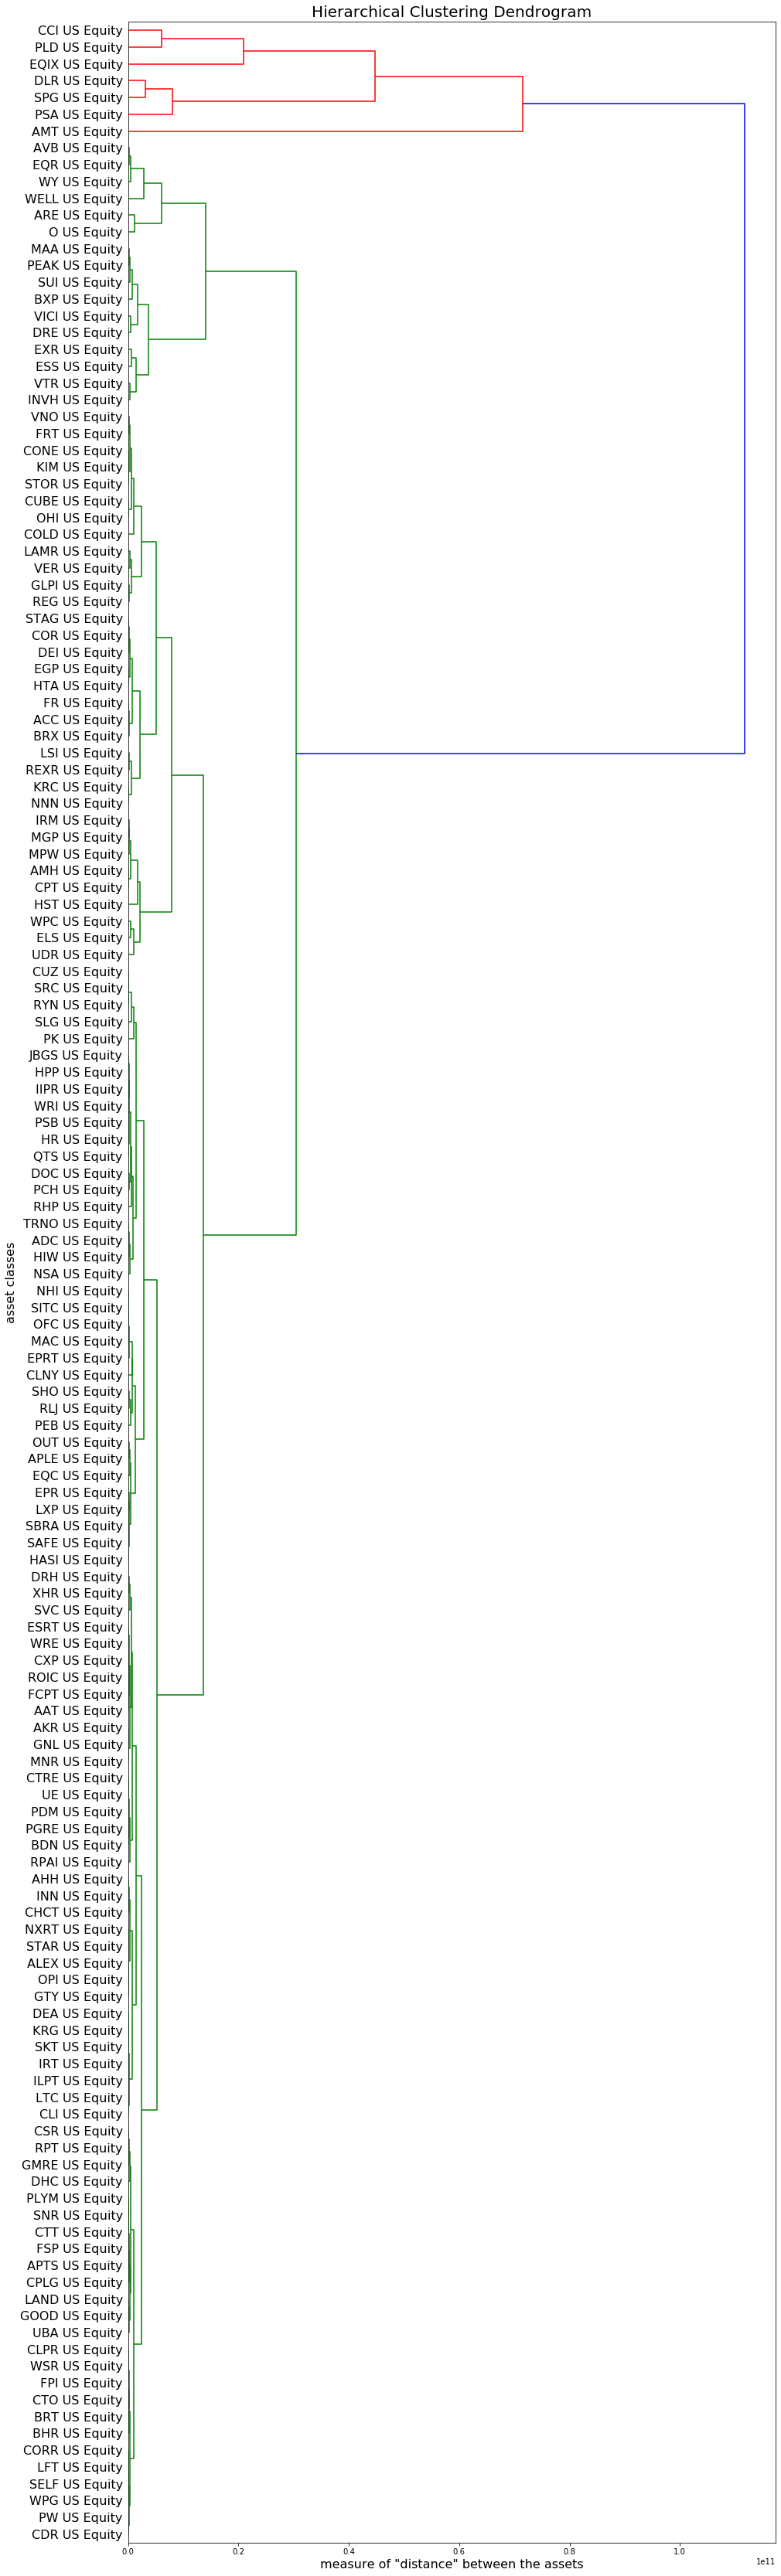

In [11]:
X = fdf.dropna()
Z = sch.linkage(X.values, method='complete')
plt.figure(figsize=(15, 60))
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.xlabel('measure of "distance" between the assets', fontsize=16)
plt.ylabel('asset classes', fontsize=16)
sch.dendrogram(
    Z,
    labels=X.index,
    orientation='right',
    distance_sort='ascending',
    leaf_font_size=16
)
plt.show()
clusters2 = pd.Series(index=X.index, data=sch.fcluster(Z, 6, criterion='maxclust')).sort_values()

In [9]:
large_text = ''
for i in sorted(list(set(clusters2.values))):
    print('Cluster #%s is:' % str(i))
    large_text += '\nCluster #%s is:' % str(i)
    for j in clusters2[clusters2 == i].index:
        print(j)
        large_text += '\n' + j
    print('______________________')
    large_text += '\n______________________'

Cluster #1 is:
GOOD US Equity
ALEX US Equity
RPAI US Equity
SAFE US Equity
CLNY US Equity
LSI US Equity
WPC US Equity
LXP US Equity
CTO US Equity
AKR US Equity
DEI US Equity
GLPI US Equity
ACC US Equity
RYN US Equity
CTT US Equity
GTY US Equity
IRM US Equity
CHCT US Equity
KRC US Equity
CORR US Equity
DOC US Equity
REXR US Equity
BHR US Equity
CTRE US Equity
EPR US Equity
CLPR US Equity
CDR US Equity
IIPR US Equity
FPI US Equity
BRX US Equity
PLYM US Equity
CXP US Equity
DHC US Equity
CSR US Equity
QTS US Equity
SELF US Equity
AMH US Equity
CUBE US Equity
AHH US Equity
CONE US Equity
LAMR US Equity
EGP US Equity
HTA US Equity
MNR US Equity
TRNO US Equity
SRC US Equity
STAG US Equity
PSB US Equity
CUZ US Equity
PW US Equity
FR US Equity
WPG US Equity
DEA US Equity
DRH US Equity
NHI US Equity
HST US Equity
JBGS US Equity
FSP US Equity
LTC US Equity
SBRA US Equity
SHO US Equity
OUT US Equity
MPW US Equity
KRG US Equity
APTS US Equity
PK US Equity
XHR US Equity
GMRE US Equity
FCPT US Equit

## Problem

So, clustering on features and clustering on correlations are not the same. We would like them to be the same in the ideal theoretical world. Hence, I would like to find a subset of features X that best explain how the assets correlate with each other.

Say, I take the assets from the correlation cluster 1:

* IOR US Equity,
* NTST US Equity,
* SAFE US Equity,
* PW US Equity
* HHDS US Equity
* IARE US Equity
* FREVS US Equity
* GMRE US Equity
* COLD US Equity

what are the subset of features, X1, in the matrix of features X that minimizes the (average? max?) distance between these assets? When I answer that question I can say things like "correlation cluster 1 are associated features X1 and "correlation cluster 1 are associated features X2", etc. Hence, we can build portfolios sorting on features X1, X2, etc. and these portfolios will by construction select assets that are similar from a performance point of view.